### Gaussian process regression

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial import distance
%matplotlib inline  
%config InlineBackend.figure_format='retina'
print ("Ready.")

Ready.


### Define an `SE` kernel function and grid function

In [2]:
def kernel_se(x1,x2,hyp={'gain':1.0,'len':1.0}):
    """
        Squared-exponential kernel function
    """
    D = distance.cdist(x1/hyp['len'],x2/hyp['len'],'sqeuclidean')
    K = hyp['gain']*np.exp(-D)
    return K
def xy_grid(x_min,x_max,x_res,y_min,y_max,y_res):
    x = np.arange(x_min,x_max,(x_max-x_min)/x_res)
    y = np.arange(y_min,y_max,(y_max-y_min)/y_res)
    xv,yv = np.meshgrid(x,y,sparse=False,indexing='xy') # [y_res x x_res]
    xy = np.concatenate((xv.reshape((-1,1)),yv.reshape((-1,1))),axis=1)
    return xy,xv,yv # [x_res*y_res x 2],  [y_rex x x_res], [y_rex x x_res]
print ("Ready.")

Ready.


### Set data

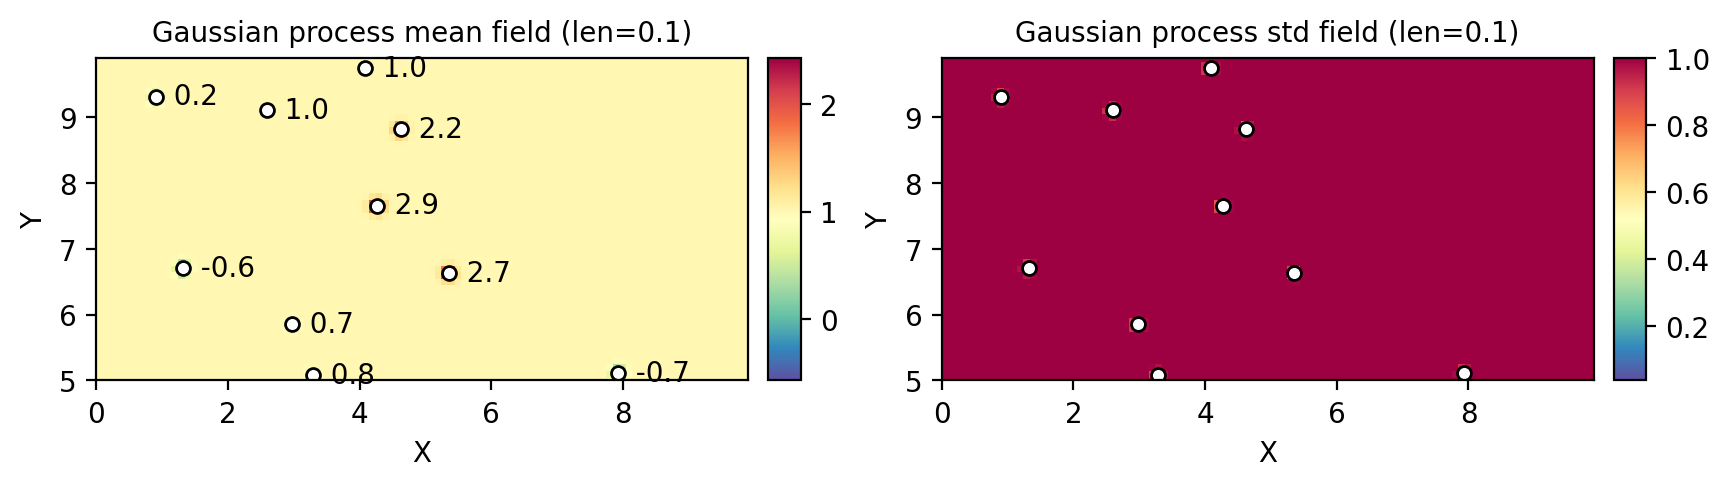

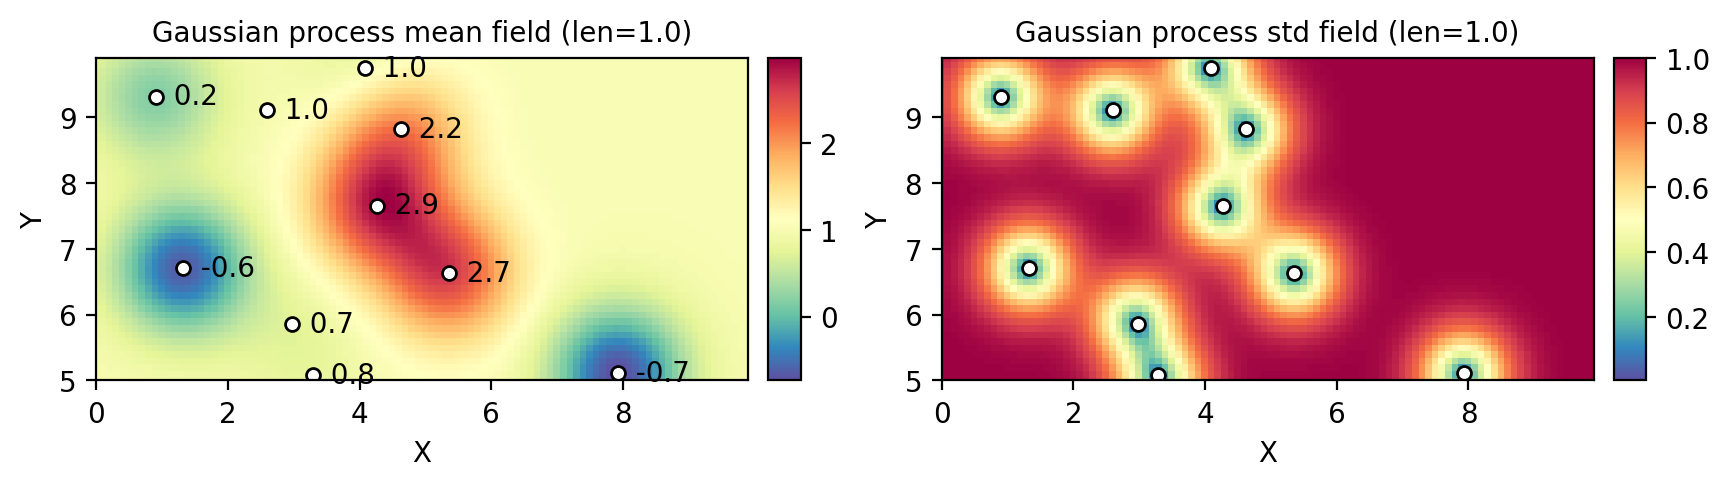

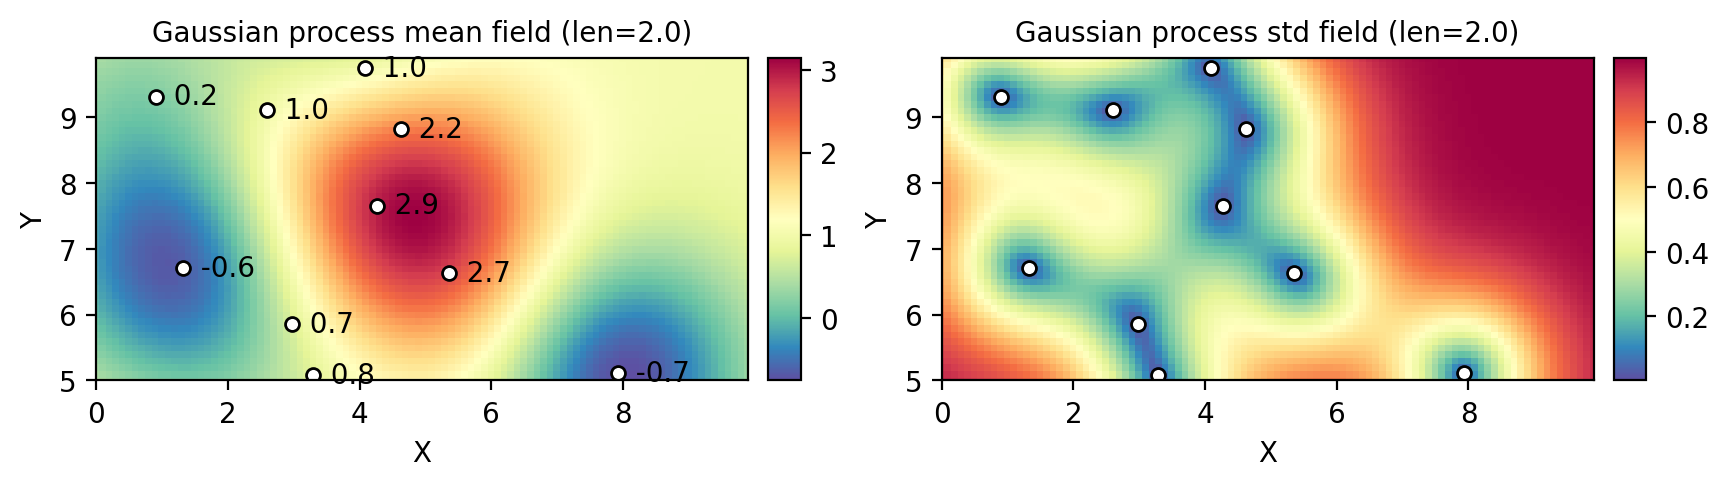

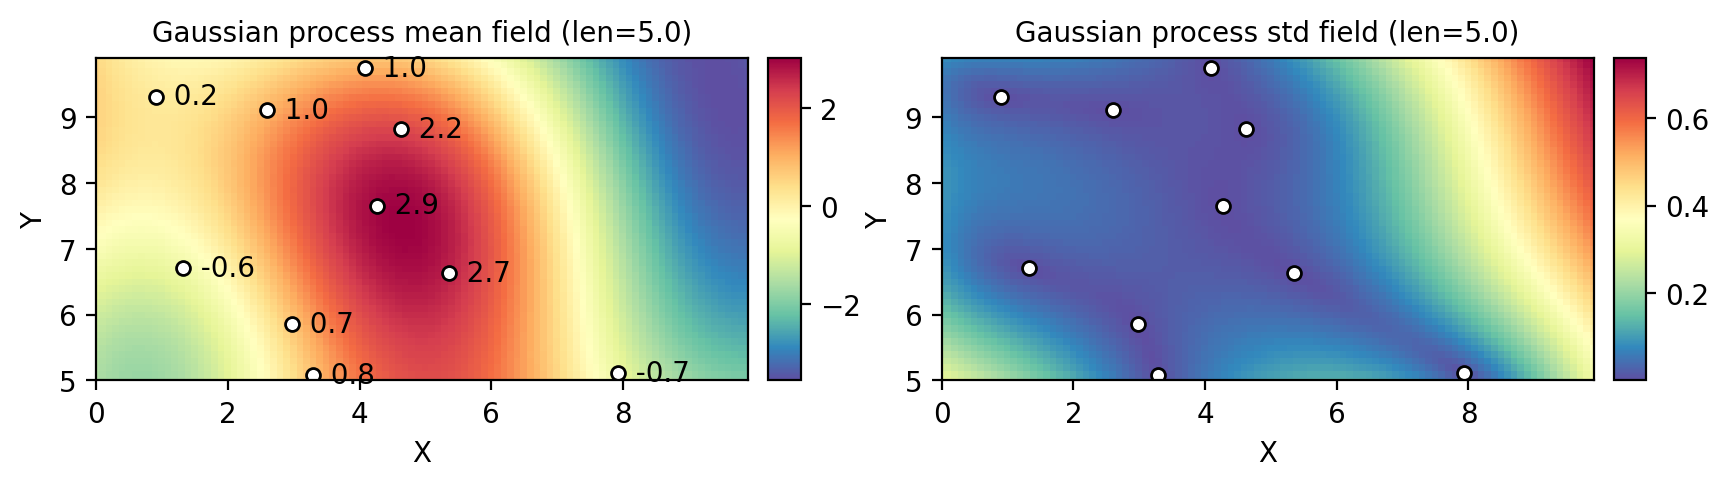

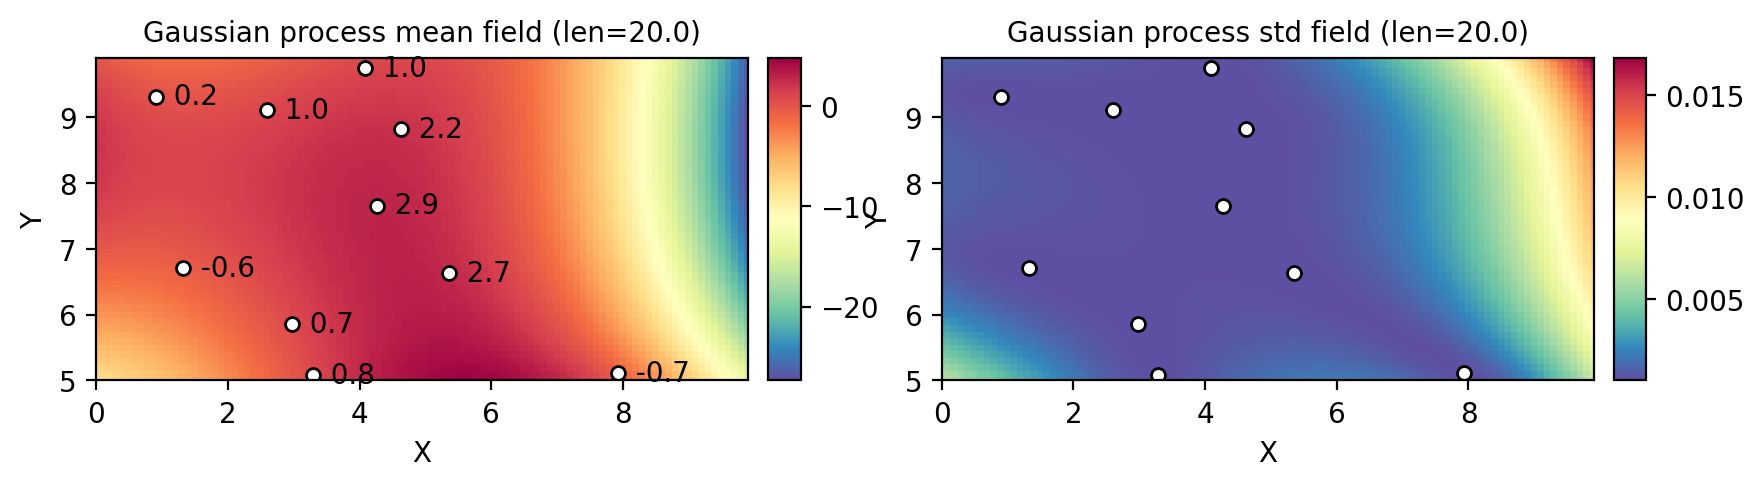

In [3]:
# Set training data
n_train = 10
xy_train = np.array([10,5])*np.random.rand(n_train,2) + np.array([0,5])
z_train = kernel_se(xy_train,xy_train,{'gain':1.0,'len':2.0}) @ \
    np.random.randn(n_train,1)
for len_val in [0.1,1.0,2.0,5.0,20.0]:
    hyp = {'gain':1.0,'len':len_val}
    # Gaussian process regression (predictive mean and variance)
    xy_test,xv_test,yv_test = xy_grid(
        x_min=0,x_max=10,x_res=100,y_min=5,y_max=10,y_res=50)
    n_test = xy_test.shape[0] # number of test data
    K_test = kernel_se(xy_test,xy_test,hyp=hyp)
    K_test_chol = np.linalg.cholesky(K_test+1e-8*np.eye(n_test))
    K_data = kernel_se(xy_train,xy_train,hyp=hyp)
    K_test_data = kernel_se(xy_test,xy_train,hyp=hyp) 
    inv_K_data = np.linalg.inv(K_data+1e-8*np.eye(n_train))
    mu_test = K_test_data @ inv_K_data @ (z_train-np.mean(z_train)) + np.mean(z_train)
    K_posterior = K_test - K_test_data @ inv_K_data @ K_test_data.T
    std_posterior_diag = np.sqrt(np.diag(K_posterior)+1e-6)

    # Plot GP mean
    plt.figure(figsize=(10,5)); plt.subplot(1,2,1); ax = plt.gca()
    im = plt.pcolor(xv_test,yv_test,mu_test.reshape(xv_test.shape),
                    cmap=matplotlib.cm.Spectral_r)
    plt.plot(xy_train[:,0],xy_train[:,1],'o',markersize=5,color='k',mew=1,mfc='w')
    for i_idx in range(n_train):
        plt.text(xy_train[i_idx,0],xy_train[i_idx,1],'  %.1f'%(z_train[i_idx,0]),
                 fontsize=10,verticalalignment='center',)
    ax.set_aspect('equal', adjustable='box')
    plt.xlabel('X',fontsize=10); plt.ylabel('Y',fontsize=10)
    plt.title('Gaussian process mean field (len=%.1f)'%(len_val),fontsize=10)
    plt.xlim([xv_test.min(),xv_test.max()]); plt.ylim([yv_test.min(),yv_test.max()]);
    plt.colorbar(im, cax=make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1))
    # Plot GP std
    plt.subplot(1,2,2); ax = plt.gca()
    im = plt.pcolor(xv_test,yv_test,std_posterior_diag.reshape(xv_test.shape),
                    cmap=matplotlib.cm.Spectral_r)
    plt.plot(xy_train[:,0],xy_train[:,1],'o',markersize=5,color='k',mew=1,mfc='w')
    ax.set_aspect('equal', adjustable='box')
    plt.xlabel('X',fontsize=10); plt.ylabel('Y',fontsize=10)
    plt.title('Gaussian process std field (len=%.1f)'%(len_val),fontsize=10)
    plt.xlim([xv_test.min(),xv_test.max()]); plt.ylim([yv_test.min(),yv_test.max()]);
    plt.colorbar(im, cax=make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1))
    plt.show()